## Loading Packages

In [65]:
import numpy as np
import pandas as pd
import re
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from IPython.display import Markdown, display
import random
pd.set_option('display.max_columns', None)

## Custom Functions

In [66]:
#building custom functions for the statiscal analysis

def Single_column_variation(df= None, column = None, min_value= 0, max_value = 0):
    df_list = list()

    for i in range(len(df)-1):

        df_list.append(pd.DataFrame(df.iloc[i]).transpose())
        # Copying each row into a new dataframe
        df_list[i] = pd.DataFrame(np.repeat(df_list[i].values, max_value-min_value, axis=0), columns=df_list[i].columns)

        for k in range(min_value, max_value):
            df_list[i][column][k] = k
    return  df_list

# make a function that predicts the parameters to maximize the probability of winning
def Best_stats(df, model=None):

    results = list()
    max_prob = list()

    for i in range(len(df)-1):
        #Predict the probability to win for the selected column
        results.append(model.predict_proba(df[i])[:,1])
        #the mac prabability is appened
        max_prob.append(results[i].argmax())

    return results, max_prob


## Loading Datasets

In [67]:
df = pd.read_csv("Datasets/games_details.csv")
seasons = pd.read_csv("Datasets/games.csv")[["GAME_ID", "SEASON"]]

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Data Overview

In [68]:
df.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22100213,1610612764,WAS,Washington,203484,Kentavious Caldwell-Pope,Kentavious,F,NaN,27:41,1.0,6.0,0.167,0.0,5.0,0.000,1.0,1.0,1.0,1.0,5.0,6.0,2.0,1.0,0.0,1.0,0.0,3.0,2.0
1,22100213,1610612764,WAS,Washington,1628398,Kyle Kuzma,Kyle,F,NaN,30:28,2.0,12.0,0.167,1.0,8.0,0.125,0.0,0.0,0.0,1.0,4.0,5.0,3.0,1.0,2.0,1.0,1.0,5.0,-14.0
2,22100213,1610612764,WAS,Washington,1629655,Daniel Gafford,Daniel,C,NaN,24:21,9.0,12.0,0.750,0.0,0.0,0.000,2.0,5.0,0.4,2.0,7.0,9.0,1.0,2.0,1.0,1.0,4.0,20.0,-2.0
3,22100213,1610612764,WAS,Washington,203078,Bradley Beal,Bradley,G,NaN,35:07,9.0,20.0,0.450,5.0,11.0,0.455,1.0,1.0,1.0,0.0,3.0,3.0,7.0,2.0,0.0,2.0,3.0,24.0,-9.0
4,22100213,1610612764,WAS,Washington,203915,Spencer Dinwiddie,Spencer,G,NaN,28:34,0.0,5.0,0.000,0.0,4.0,0.000,0.0,0.0,0.0,0.0,3.0,3.0,2.0,0.0,0.0,2.0,1.0,0.0,-5.0


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626111 entries, 0 to 626110
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   GAME_ID            626111 non-null  int64  
 1   TEAM_ID            626111 non-null  int64  
 2   TEAM_ABBREVIATION  626111 non-null  object 
 3   TEAM_CITY          626111 non-null  object 
 4   PLAYER_ID          626111 non-null  int64  
 5   PLAYER_NAME        626111 non-null  object 
 6   NICKNAME           10485 non-null   object 
 7   START_POSITION     239375 non-null  object 
 8   COMMENT            102359 non-null  object 
 9   MIN                523751 non-null  object 
 10  FGM                523751 non-null  float64
 11  FGA                523751 non-null  float64
 12  FG_PCT             523751 non-null  float64
 13  FG3M               523751 non-null  float64
 14  FG3A               523751 non-null  float64
 15  FG3_PCT            523751 non-null  float64
 16  FT

## Data Cleaning


removing the game_id,team_id, player_ids from the stats

In [70]:
df.drop(["GAME_ID", "TEAM_ID", "PLAYER_ID"], axis=1).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
FGM,523751.0,3.574498,3.019116,0.0,1.00,3.000,5.000,28.0
FGA,523751.0,7.878062,5.657840,0.0,3.00,7.000,11.000,50.0
FG_PCT,523751.0,0.415843,0.251636,0.0,0.25,0.429,0.571,1.0
FG3M,523751.0,0.753051,1.205652,0.0,0.00,0.000,1.000,14.0
FG3A,523751.0,2.115030,2.521680,0.0,0.00,1.000,3.000,24.0
FG3_PCT,523751.0,0.197427,0.289293,0.0,0.00,0.000,0.375,1.0
FTM,523751.0,1.738716,2.356272,0.0,0.00,1.000,3.000,26.0
FTA,523751.0,2.294722,2.892114,0.0,0.00,2.000,4.000,39.0
FT_PCT,523751.0,0.436454,0.427786,0.0,0.00,0.500,0.909,1.0
OREB,523751.0,1.028187,1.401890,0.0,0.00,1.000,2.000,18.0


Removing the duplicated data from the dataset including players that might appear more that once

In [71]:
df[df.duplicated(subset=["GAME_ID", "PLAYER_ID"], keep="first")]

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
23427,22000069,1610612763,MEM,Memphis,1628960,Grayson Allen,NaN,NaN,DNP - Injury/Illness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23428,22000069,1610612763,MEM,Memphis,1629007,Jontay Porter,NaN,NaN,DNP - Injury/Illness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23429,22000069,1610612763,MEM,Memphis,1630214,Xavier Tillman,NaN,NaN,DNP - Injury/Illness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23430,22000069,1610612766,CHA,Charlotte,1630176,Vernon Carey Jr.,NaN,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23431,22000069,1610612766,CHA,Charlotte,1628370,Malik Monk,NaN,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40312,22000002,1610612747,LAL,Los Angeles,2544,LeBron James,NaN,F,NaN,28:21,7.0,17.0,0.412,3.0,8.0,0.375,5.0,7.0,0.714,2.0,3.0,5.0,5.0,0.0,0.0,4.0,2.0,22.0,2.0
40313,22000002,1610612747,LAL,Los Angeles,203484,Kentavious Caldwell-Pope,NaN,G,NaN,23:03,2.0,4.0,0.500,1.0,3.0,0.333,4.0,4.0,1.000,0.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,9.0,-9.0
40314,22000002,1610612747,LAL,Los Angeles,203471,Dennis Schroder,NaN,G,NaN,27:48,5.0,15.0,0.333,2.0,5.0,0.400,2.0,4.0,0.500,1.0,11.0,12.0,8.0,0.0,0.0,1.0,4.0,14.0,-10.0
40315,22000002,1610612747,LAL,Los Angeles,1628398,Kyle Kuzma,NaN,NaN,NaN,26:38,6.0,11.0,0.545,1.0,3.0,0.333,2.0,2.0,1.000,0.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,15.0,1.0


In [72]:
df.drop_duplicates(subset=["GAME_ID", "PLAYER_ID"], keep="first", inplace=True)

## Data Filling

We want to group up and sum the statistics for every player within each unique game played. We expect some columns to lose value by doing so especially player_id, the plus minus  and the shot percentage lose meaning. However some of these can be recalculated. This will remove some NaN value and some columns not really that important

In [73]:
df = df.groupby(["GAME_ID", "TEAM_ID"]).sum().reset_index().drop(['PLAYER_ID', 'FG_PCT','FG3_PCT','FT_PCT','PLUS_MINUS'], axis= 1)

In [74]:
df["FG_PCT"] = df["FGM"]/df["FGA"]*100
df["FG3_PCT"] = df["FG3M"]/df["FG3A"]*100
df["FT_PCT"] = df["FTM"]/df["FTA"]*100

Removing anomalous data

In [75]:
print (f"Dataset has {df.isna().sum().sum()} null values.\n")
print ("There seems to a game with 3 unique rows.\n")

print(df["GAME_ID"].value_counts().sort_values().tail())

display(df[df["GAME_ID"] == 10500109])

#dropping this row due for data readability
df = df.drop(index=335, axis=0).reset_index().drop("index", axis=1)

Dataset has 3 null values.

There seems to a game with 3 unique rows.

20701124    2
21100481    2
21200784    2
21000146    2
10500109    3
Name: GAME_ID, dtype: int64


,GAME_ID,TEAM_ID,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,FG_PCT,FG3_PCT,FT_PCT
334,10500109,1610612742,36.0,73.0,5.0,16.0,26.0,35.0,10.0,27.0,37.0,18.0,8.0,9.0,13.0,19.0,103.0,49.315068,31.250000,74.285714
335,10500109,1610612756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
336,10500109,1610612765,40.0,87.0,4.0,9.0,13.0,15.0,15.0,26.0,41.0,20.0,7.0,11.0,13.0,29.0,97.0,45.977011,44.444444,86.666667


We need to develop a "victory" label to develop our ML model. Also need to factor in miss data entire due to instances where the games tie and have to go into overtime.

The "victory" labels is calculated by comparing the point made in a unique game and defining it as a  "Yes" or "No"

In [76]:
# sort the datafrome by GAME_Id to avoid in the following code to define the victory label
df = df.sort_values("GAME_ID")
df["VICTORY"] = ""

#check for victory condition and update the "Victory" column
for i in range(0, len(df)-1, 2):
    if df["PTS"][i] > df["PTS"][i+1]:
        df.loc[i, "VICTORY"] = "YES"
        df.loc[i+1, "VICTORY"] = "NO"
    elif df["PTS"][i] < df["PTS"][i+1]:
        df.loc[i, "VICTORY"] = "NO"
        df.loc[i+1, "VICTORY"] = "YES"
    else:
        print(f"Potential tie game {df.iloc[i]}")


Potential tie game GAME_ID      20400769
TEAM_ID    1610612738
FGM              29.0
FGA              64.0
FG3M              4.0
FG3A             11.0
FTM              26.0
FTA              34.0
OREB              9.0
DREB             33.0
REB              42.0
AST              17.0
STL              10.0
BLK               6.0
TO               22.0
PF               25.0
PTS              88.0
FG_PCT        45.3125
FG3_PCT     36.363636
FT_PCT      76.470588
VICTORY              
Name: 7134, dtype: object
Potential tie game GAME_ID      20401079
TEAM_ID    1610612751
FGM              37.0
FGA              84.0
FG3M              5.0
FG3A             23.0
FTM              23.0
FTA              33.0
OREB             12.0
DREB             31.0
REB              43.0
AST              22.0
STL               7.0
BLK               3.0
TO               13.0
PF               31.0
PTS             102.0
FG_PCT      44.047619
FG3_PCT      21.73913
FT_PCT       69.69697
VICTORY              
Name: 7754, 

Adding back the season label to begin exploring the evolutions and impact of the 3 ball in the NBA

In [77]:
df = pd.merge(df, seasons, how="left", on="GAME_ID")

In [78]:
df.head()

,GAME_ID,TEAM_ID,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,FG_PCT,FG3_PCT,FT_PCT,VICTORY,SEASON
0,10300001,1610612742,34.0,76.0,2.0,8.0,15.0,30.0,12.0,26.0,38.0,20.0,9.0,4.0,18.0,34.0,85.0,44.736842,25.000000,50.000000,NO,2003
1,10300001,1610612762,32.0,70.0,1.0,7.0,25.0,34.0,9.0,32.0,41.0,23.0,8.0,4.0,18.0,26.0,90.0,45.714286,14.285714,73.529412,YES,2003
2,10300002,1610612749,32.0,75.0,2.0,13.0,28.0,40.0,11.0,32.0,43.0,20.0,9.0,4.0,24.0,26.0,94.0,42.666667,15.384615,70.000000,NO,2003
3,10300002,1610612763,40.0,81.0,4.0,15.0,21.0,34.0,14.0,34.0,48.0,25.0,18.0,7.0,25.0,35.0,105.0,49.382716,26.666667,61.764706,YES,2003
4,10300003,1610612739,38.0,77.0,4.0,6.0,20.0,29.0,12.0,40.0,52.0,25.0,10.0,7.0,25.0,33.0,100.0,49.350649,66.666667,68.965517,YES,2003


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49850 entries, 0 to 49849
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GAME_ID  49850 non-null  int64  
 1   TEAM_ID  49850 non-null  int64  
 2   FGM      49850 non-null  float64
 3   FGA      49850 non-null  float64
 4   FG3M     49850 non-null  float64
 5   FG3A     49850 non-null  float64
 6   FTM      49850 non-null  float64
 7   FTA      49850 non-null  float64
 8   OREB     49850 non-null  float64
 9   DREB     49850 non-null  float64
 10  REB      49850 non-null  float64
 11  AST      49850 non-null  float64
 12  STL      49850 non-null  float64
 13  BLK      49850 non-null  float64
 14  TO       49850 non-null  float64
 15  PF       49850 non-null  float64
 16  PTS      49850 non-null  float64
 17  FG_PCT   49850 non-null  float64
 18  FG3_PCT  49850 non-null  float64
 19  FT_PCT   49850 non-null  float64
 20  VICTORY  49850 non-null  object 
 21  SEASON   498

## Exploratory Data Analysis


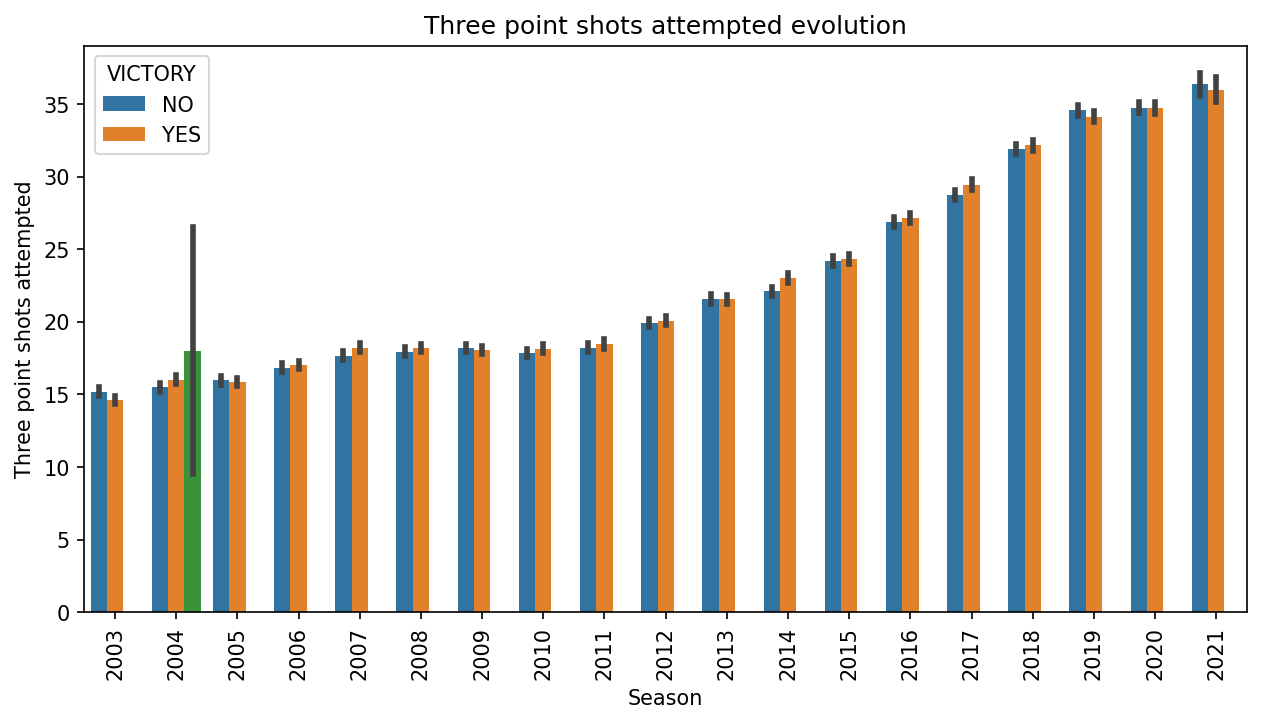

In [80]:
plt.figure(figsize=(10,5), dpi=150)
ax = sns.barplot(data=df, x="SEASON", y="FG3A", hue="VICTORY")

ax.set(ylabel="Three point shots attempted", xlabel="Season")
ax.set_title("Three point shots attempted evolution")

plt.xticks(rotation=90);

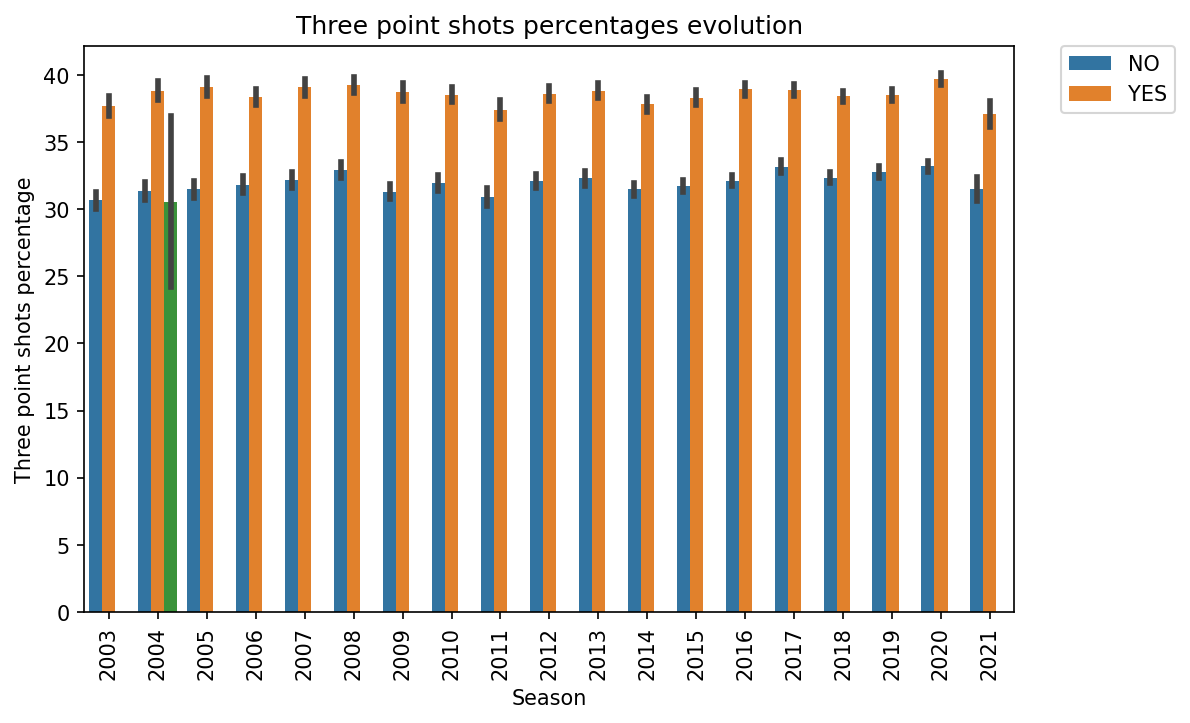

In [81]:
plt.figure(figsize=(8,5),dpi=150)
ax = sns.barplot(data=df,x="SEASON",y="FG3_PCT",hue="VICTORY")

ax.set(ylabel="Three point shots percentage", xlabel="Season")
ax.set_title("Three point shots percentages evolution")
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.xticks(rotation=90);

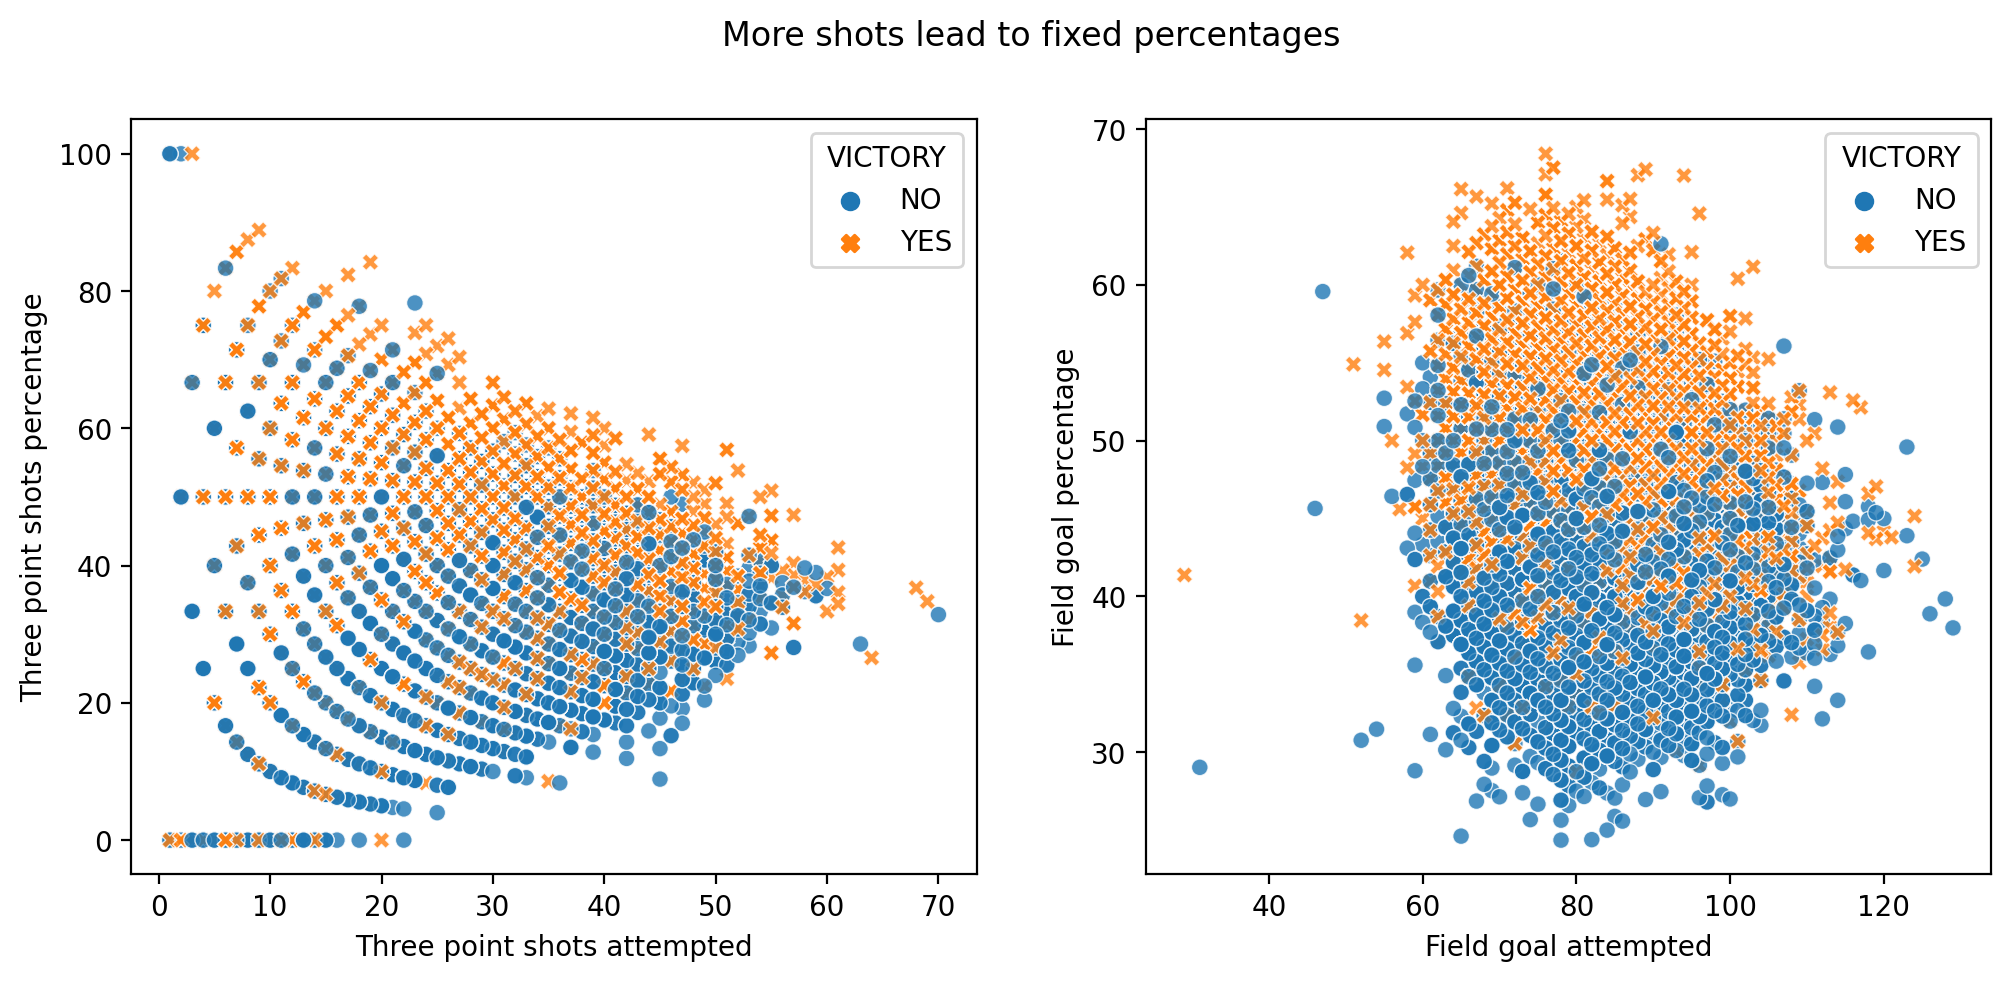

In [82]:
fig, ax = plt.subplots(1,2,figsize=(12,5),dpi=200)

plt.suptitle("More shots lead to fixed percentages")

sns.scatterplot(ax = ax[0],data=df,x="FG3A",y="FG3_PCT",hue="VICTORY",style="VICTORY",alpha=0.8)
ax[0].set(ylabel="Three point shots percentage", xlabel="Three point shots attempted")

sns.scatterplot(ax = ax[1],data=df,x="FGA",y="FG_PCT",hue="VICTORY",style="VICTORY",alpha=0.8)
ax[1].set(ylabel="Field goal percentage", xlabel="Field goal attempted")

plt.show()

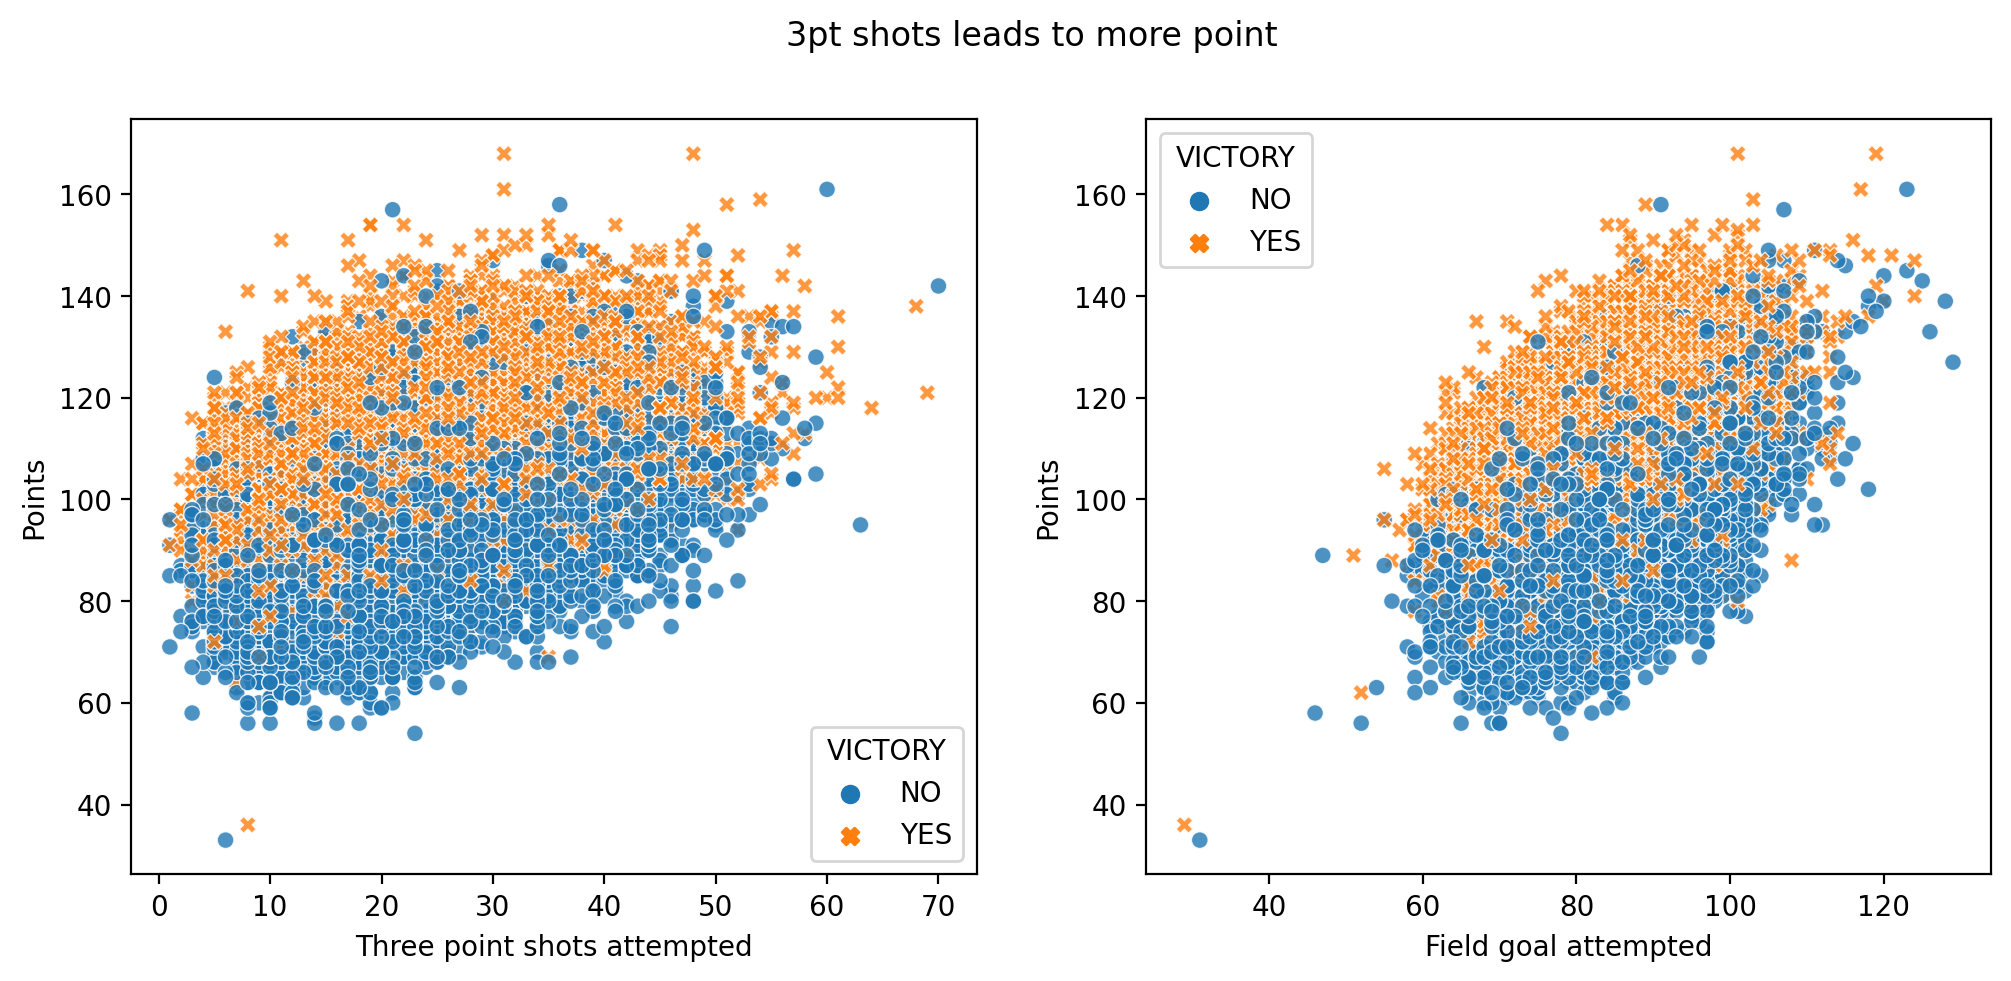

In [83]:
fig, ax = plt.subplots(1,2,figsize=(12,5), dpi=200)

plt.suptitle("3pt shots leads to more point")

sns.scatterplot(ax = ax[0], data = df, y = "PTS", x = "FG3A", hue = "VICTORY",style="VICTORY",alpha=0.8)
ax[0].set(xlabel="Three point shots attempted", ylabel="Points")

sns.scatterplot(ax = ax[1], data=df, y="PTS", x="FGA", hue="VICTORY",style="VICTORY",alpha=0.8)
ax[1].set(xlabel="Field goal attempted", ylabel="Points")

plt.show()

## Hypothesis Builiding

Correalation Map of features

## Feature Engineering & Selection
 Will be splitting the dataset to 3 phrase in the nba including:

 1.2003-2006
 2.2007-2015
 3.2016-2020

The reason for this is 2006 and 2017 a pivotal years for 3 point shooting in NBA.
2006 was when Daryl Morey was hired and introduced data analytics in the NBA.
2017 was when Stephen Curry wins the 2nd MVP of the regular season, arguably the best 3 point shooter of all time.

In [84]:
#split dataset into 3 parts
first_era = df[df["SEASON"] < 2007]
second_era = df[(df["SEASON"] >= 2007) & (df["SEASON"] < 2016)]
third_era = df[df["SEASON"] >= 2016]


## ML Model Selection
Selecting the Random Forest Classifier as the ML model with the following features:

Field goals attempted per game
Three point shots attempted per game
Free throws attempted per game
Field goals percentage per game
Three point shots percentage per game
Free throws percentage per game
Offensive rebounds per game
Defensive rebounds per game
Assists per game
Steels per game
Blocks per game
Turnovers per game
Fouls per game

Dropping the field goal, three point made and points which are the most important features which shall me modelled latter and not impact the prediction.

## ML Fit & Training

In [85]:
# ML model for the first chunk of data (2003-2012)

#Split

X1 = first_era.drop(["SEASON","VICTORY","FGM","FTM","FG3M","PTS","GAME_ID","TEAM_ID","REB"],axis=1)
y1 = first_era["VICTORY"]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=40)

#Train

model_first_split = RandomForestClassifier(bootstrap=True)
model_first_split.fit(X1_train,y1_train)


# ML model for the second chunk of data (2012-2016)

#Split

X2 = second_era.drop(["SEASON","VICTORY","FGM","FTM","FG3M","PTS","GAME_ID","TEAM_ID","REB"],axis=1)
y2 = second_era["VICTORY"]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=40)

#Train

model_second_split = RandomForestClassifier(bootstrap=True)
model_second_split.fit(X2_train,y2_train)


# ML model for the third chunk of data (2016-2020)

#Split

X3 = third_era.drop(["SEASON","VICTORY","FGM","FTM","FG3M","PTS","GAME_ID","TEAM_ID","REB"],axis=1)
y3 = third_era["VICTORY"]

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=40)

#Train

model_third_split = RandomForestClassifier(bootstrap=True)
model_third_split.fit(X3_train,y3_train)



RandomForestClassifier()

RandomForestClassifier()

## ML Validation Testing

## ML Prediction and Analysis

In [86]:
#Predict

y1_pred = model_first_split.predict(X1_test)
#Predict

y2_pred = model_second_split.predict(X2_test)
#Predict

y3_pred = model_third_split.predict(X3_test)

In [87]:
print("These are the results for the years from (2003-2006)\n")
print(classification_report(y1_test,y1_pred))

print("These are the results for the years from (2007-2015)\n")
print(classification_report(y2_test,y2_pred))

print("These are the results for the years from (2016-2020)\n")
print(classification_report(y3_test,y3_pred))

These are the results for the years from (2003-2006)

              precision    recall  f1-score   support

                   0.00      0.00      0.00         2
          NO       0.81      0.82      0.81      1668
         YES       0.81      0.80      0.81      1630

    accuracy                           0.81      3300
   macro avg       0.54      0.54      0.54      3300
weighted avg       0.81      0.81      0.81      3300

These are the results for the years from (2007-2015)

              precision    recall  f1-score   support

          NO       0.81      0.82      0.82      3722
         YES       0.82      0.81      0.82      3759

    accuracy                           0.82      7481
   macro avg       0.82      0.82      0.82      7481
weighted avg       0.82      0.82      0.82      7481

These are the results for the years from (2016-2020)



C:\Users\sasmi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sasmi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sasmi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          NO       0.82      0.84      0.83      2083
         YES       0.83      0.81      0.82      2093

    accuracy                           0.82      4176
   macro avg       0.82      0.82      0.82      4176
weighted avg       0.82      0.82      0.82      4176



## Partial Derivation Plots

In [88]:
first_split_list = Single_column_variation(X1_test,"FG3A",0,60)
results_first_split, max_prob_first_split = Best_stats(first_split_list, model_first_split)

second_split_list = Single_column_variation(X2_test,"FG3A",0,60)
results_second_split, max_prob_second_split = Best_stats(second_split_list, model_second_split)

third_split_list = Single_column_variation(X3_test,"FG3A",0,60)
results_third_split, max_prob_third_split = Best_stats(third_split_list, model_third_split)

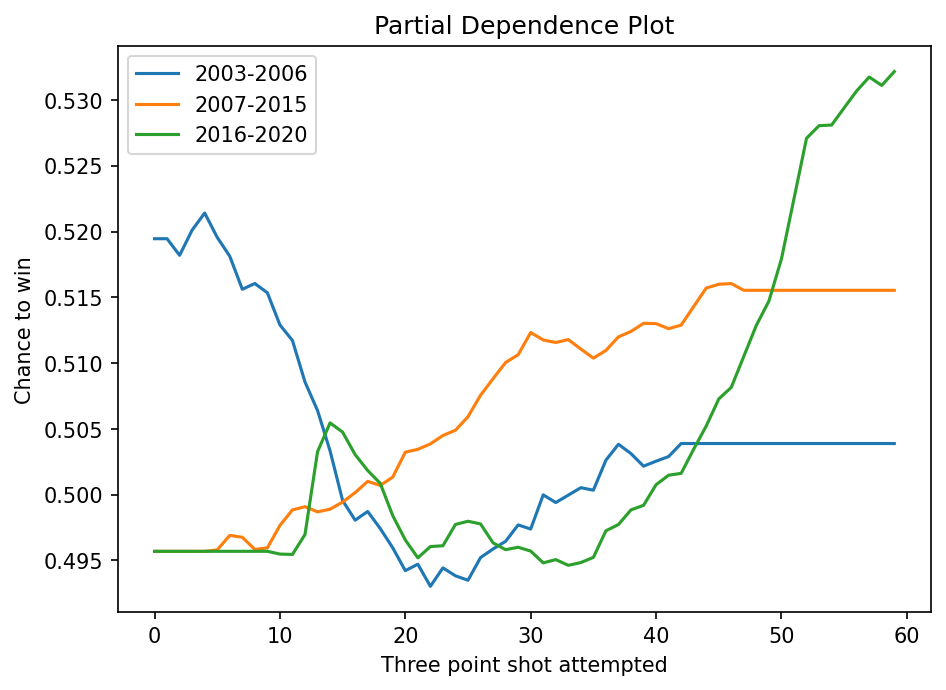

In [89]:
average1 = np.sum(results_first_split,axis=0)/len(results_first_split)
average2 = np.sum(results_second_split,axis=0)/len(results_second_split)
average3 = np.sum(results_third_split,axis=0)/len(results_third_split)

plt.figure(figsize=(7,5),dpi=150)

plt.plot(range(60),average1)
plt.plot(range(60),average2)
plt.plot(range(60),average3)

plt.legend(["2003-2006","2007-2015","2016-2020"])
plt.xlabel("Three point shot attempted")
plt.ylabel("Chance to win")
plt.title("Partial Dependence Plot")

plt.show()

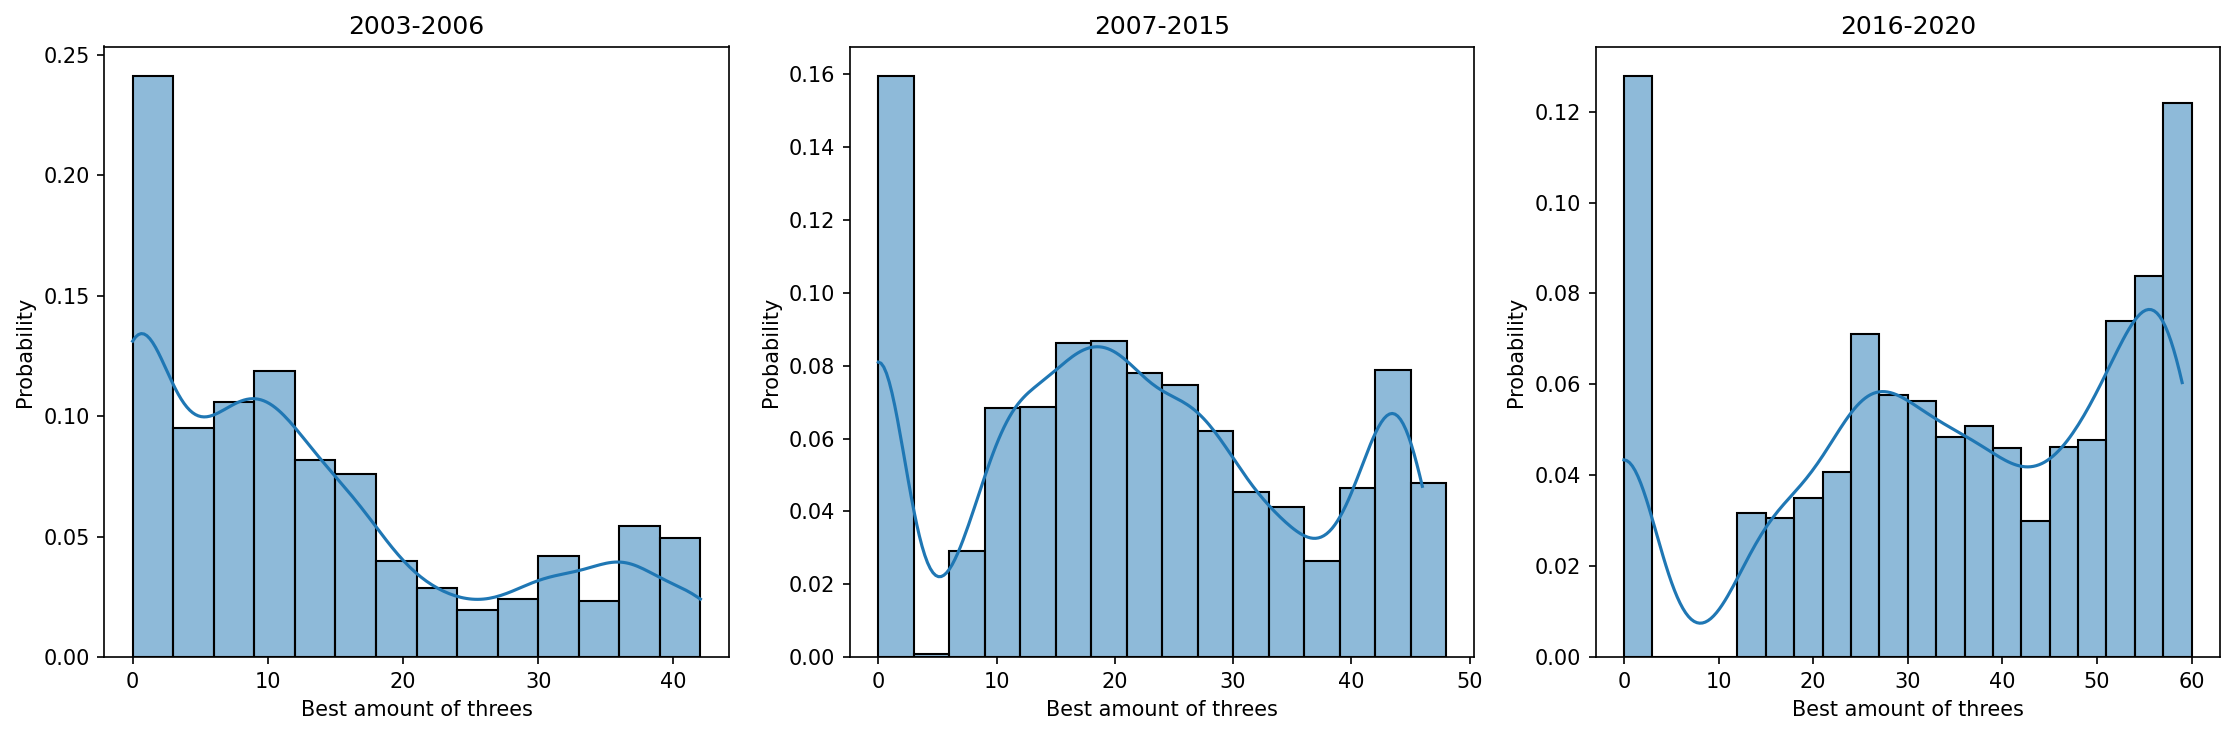

In [90]:
fig, ax = plt.subplots(1,3, figsize=(15,5), dpi=150)

sns.histplot(ax = ax[0], x = max_prob_first_split, kde=True, stat="probability", binwidth=3)
ax[0].set(xlabel="Best amount of threes", title="2003-2006")

sns.histplot(ax = ax[1], x = max_prob_second_split, kde=True, stat="probability", binwidth=3)
ax[1].set(xlabel="Best amount of threes", title="2007-2015")

sns.histplot(ax = ax[2], x = max_prob_third_split, kde=True, stat="probability", binwidth=3)
ax[2].set(xlabel="Best amount of threes", title="2016-2020")

plt.tight_layout()
plt.show()

In [91]:
old_school_pred = model_third_split.predict_proba(X1)
new_school_pred = model_first_split.predict_proba(X3)

lose_mean_old = old_school_pred.mean(axis=0)[0]
win_mean_old = old_school_pred.mean(axis=0)[1]
lose_mean_new = new_school_pred.mean(axis=0)[0]
win_mean_new = new_school_pred.mean(axis=0)[1]

print("Old style team playing in the modern NBA win rate  =", win_mean_old,
      "\nNew style team playin in the past NBA win rate =", win_mean_new)

Old style team playing in the modern NBA win rate  = 0.3789752682305884 
New style team playin in the past NBA win rate = 0.3851745940508686


In [92]:
print(old_school_pred)

[[0.77 0.23]
 [0.76 0.24]
 [0.81 0.19]
 ...
 [0.68 0.32]
 [0.95 0.05]
 [0.6  0.4 ]]


In [93]:
print(new_school_pred)

[[0.   0.45 0.55]
 [0.02 0.75 0.23]
 [0.   0.6  0.4 ]
 ...
 [0.   0.05 0.95]
 [0.   0.36 0.64]
 [0.   0.46 0.54]]
